# This file is used for exploring the data

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import hist
import math
import sqlite3

In [2]:
# Read in the data
courses = pd.read_csv('data/courses.csv')
assessments = pd.read_csv('data/assessments.csv')
vle = pd.read_csv('data/vle.csv')
students = pd.read_csv('data/studentInfo.csv')
student_registration = pd.read_csv('data/studentRegistration.csv')
student_assessments = pd.read_csv('data/studentAssessment.csv')
student_vle = pd.read_csv('data/studentVle.csv')

con = sqlite3.connect("data/ou.db")
cur = con.cursor()

In [7]:
test_assessments = student_assessments.copy(deep=True)

def add_time_before_deadline():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['time_before_deadline'] = joined_assessments['date_submitted'] - joined_assessments['date']
    
def drop_banked():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['is_banked'] = joined_assessments['is_banked']
    test_assessments = test_assessments[student_assessments.is_banked == 0]
    
def add_assessment_info():
    global test_assessments
    joined_assessments = pd.merge(test_assessments, assessments, on='id_assessment')
    test_assessments['weight'] = joined_assessments['weight']
    test_assessments['TMA'] = joined_assessments['assessment_type'] == "TMA"
    test_assessments['Exam'] = joined_assessments['assessment_type'] == "Exam"
    test_assessments['CMA'] = joined_assessments['assessment_type'] == "CMA"

def add_previous_average():
    global test_assessments
    # Use a sqlite database to make some calculations a lot quicker
    cur.execute('''
    SELECT (SELECT AVG(score)
        FROM assessments
                 JOIN student_assessments ON assessments.id_assessment = assessments.id_assessment AND
                                             student_assessments.id_student = sa.id_student
        WHERE date < a.date
          AND code_module = a.code_module
          AND assessments.code_presentation = a.code_presentation)
FROM assessments a
         JOIN student_assessments sa ON a.id_assessment = sa.id_assessment;
         ''')
    test_assessments['prev_avg'] = pd.DataFrame(cur.fetchall(), columns=['avg'])['avg']

    
# One hot encoding for assessment type
add_time_before_deadline()
drop_banked()
add_assessment_info()
add_previous_average()

test_assessments.head()

vle.activity_type.value_counts()

# total days worked on, total time worked on, last average


resource          2660
subpage           1055
oucontent          996
url                886
forumng            194
quiz               127
page               102
oucollaborate       82
questionnaire       61
ouwiki              49
dataplus            28
externalquiz        26
homepage            22
glossary            21
ouelluminate        21
dualpane            20
repeatactivity       5
htmlactivity         4
sharedsubpage        3
folder               2
Name: activity_type, dtype: int64

114108


(array([5.100e+01, 2.000e+00, 3.000e+00, 5.000e+00, 5.000e+00, 5.000e+00,
        7.000e+00, 6.000e+00, 5.000e+00, 4.000e+00, 2.100e+01, 1.600e+01,
        8.000e+00, 2.400e+01, 1.100e+01, 1.700e+01, 1.500e+01, 2.000e+01,
        1.800e+01, 2.100e+01, 6.700e+01, 2.100e+01, 3.500e+01, 3.000e+01,
        2.900e+01, 3.300e+01, 2.900e+01, 2.800e+01, 3.200e+01, 4.500e+01,
        6.000e+01, 5.100e+01, 3.700e+01, 6.400e+01, 2.400e+01, 6.100e+01,
        6.200e+01, 3.200e+01, 8.900e+01, 5.800e+01, 3.380e+02, 5.400e+01,
        1.130e+02, 8.500e+01, 1.250e+02, 1.220e+02, 9.300e+01, 9.600e+01,
        1.460e+02, 1.240e+02, 2.670e+02, 1.140e+02, 1.760e+02, 1.680e+02,
        2.040e+02, 2.390e+02, 2.630e+02, 1.830e+02, 3.110e+02, 1.990e+02,
        9.200e+02, 2.390e+02, 3.120e+02, 2.890e+02, 3.530e+02, 4.930e+02,
        3.320e+02, 4.180e+02, 4.390e+02, 3.990e+02, 6.940e+02, 3.780e+02,
        5.440e+02, 5.350e+02, 5.090e+02, 6.780e+02, 5.320e+02, 4.310e+02,
        7.920e+02, 4.520e+02, 2.100e+0

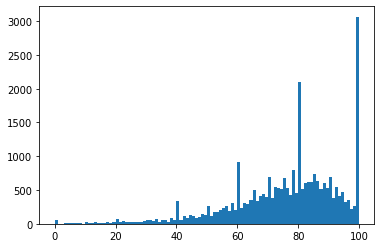

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer

test_assessments = test_assessments.dropna()
# 100 and 80 needs to be dealt with, too many of them
#test_assessments = test_assessments[test_assessments.score != 100]
#test_assessments = test_assessments[test_assessments.score != 80]
X = test_assessments
X = X.drop(["id_assessment", "id_student", "is_banked", "score", "date_submitted"], axis=1)

y = test_assessments.score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(len(X_train))
hist(y_test, bins=100)

17.638031369878842
27.933581817668326
22.85029565449601


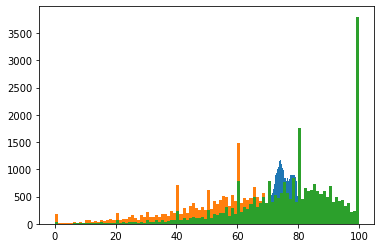

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

models = [
    LinearRegression(),
    KNeighborsClassifier(),
    #MLPClassifier(),
    RandomForestClassifier(random_state=0)
]

for model in models:
    model.fit(X_train, y_train)
    y_prediction = model.predict(X_test)
    print(math.sqrt(mean_squared_error(y_test, y_prediction)))
    hist(y_prediction, bins=100)